# [E-08] NEWS Summary

> 목차
-


**1. 개요**  
    
    1.1 프로젝트 과정 및 목표  
    1.2 예상되는 문제점   

**2. 루브릭 평가기준**  

**3. Project**
    
    3.1 실험환경 Set - up    
    3.2 데이터 준비하기  
    3.3 데이터 시각화  
    3.4 CNN 모델링
    3.5 데이터 imbalance 처리
    3.6 모델 훈련
    3.7 결과 확인과 시각화
    
**4. 회고**
    
    4.1 결과 평가  
    4.2 어려웠던 점
    

---
> **1. 개요**
-

> **1.1 프로젝트 과정 및 목표**

**<프로젝트 과정>**
1. 실험환경 Set - up    
2. 데이터 준비하기  
3. 데이터 시각화  
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

> **1.2 예상되는 문제점**

훈련에 걸리는 시간이 많아서 한번 한번의 시도에 좀 더 생각하고 해야되는 점이 어려울 것 같았습니다.

---
> **2. 루브릭 평가기준**
-

|평가문항 | 상세기준|
|:---------|:---------|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. | 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. | regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.| Accuracy 기준 85%에 도달하였다.|

---
> **3. Project**
-

> 3.1 실험환경 Set - up    

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [49]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


>3.2 데이터 준비하기  

In [50]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [51]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [52]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [53]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [54]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [55]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [56]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [57]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [58]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [59]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [60]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [61]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [62]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

>3.3 데이터 시각화  

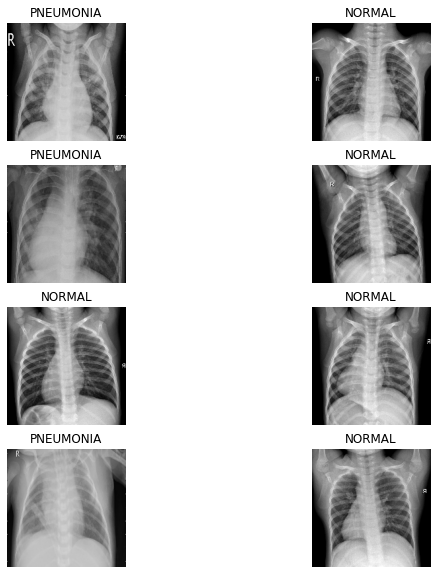

In [63]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

>3.4 CNN 모델링

In [64]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [65]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [66]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

>3.5 데이터 imbalance 처리

In [67]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


>3.6 모델 훈련

In [68]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [69]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
523/523 [==============================] - 59s 96ms/step - loss: 0.4716 - accuracy: 0.7837 - precision: 0.9364 - recall: 0.7611 - val_loss: 0.6759 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
523/523 [==============================] - 50s 95ms/step - loss: 0.3534 - accuracy: 0.8425 - precision: 0.9562 - recall: 0.8263 - val_loss: 0.2584 - val_accuracy: 0.8721 - val_precision: 0.8523 - val_recall: 0.9987
Epoch 3/10
523/523 [==============================] - 49s 94ms/step - loss: 0.3077 - accuracy: 0.8657 - precision: 0.9607 - recall: 0.8546 - val_loss: 0.3051 - val_accuracy: 0.8337 - val_precision: 0.8150 - val_recall: 1.0000
Epoch 4/10
523/523 [==============================] - 50s 96ms/step - loss: 0.3307 - accuracy: 0.8614 - precision: 0.9551 - recall: 0.8538 - val_loss: 0.6821 - val_accuracy: 0.6788 - val_precision: 1.0000 - val_recall: 0.5634
Epoch 5/10
523/523 [==============================] - 52s 99ms/step - loss: 0.3315 - accuracy: 0

>3.7 결과 확인과 시각화

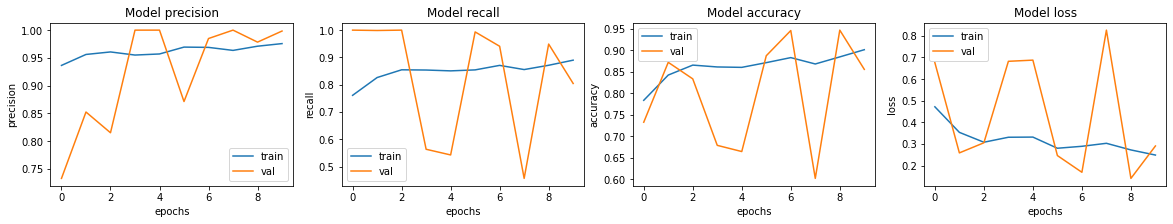

In [70]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [71]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 4s 55ms/step - loss: 0.3906 - accuracy: 0.8510 - precision: 0.9114 - recall: 0.8436
Loss: 0.390581339597702,
Accuracy: 0.8509615659713745,
Precision: 0.9113573431968689,
Recall: 0.843589723110199


> **4. 회고**
-

> 4.1 결과 평가

## <1차 시도>

Loss: 0.9717956781387329,  
Accuracy: 0.8381410241127014,  
Precision: 0.7979381680488586,  
Recall: 0.9923076629638672  

+ batch size : 32
+ epochs : 25

정확도가 83.8%가 나왔다 과적합의 가능성도 있을 수 있으니 에폭을 10으로 줄여서 다시 시도해봐야 겠다.  


## <2차 시도>

Loss: 0.7264535427093506,  
Accuracy: 0.8141025900840759,  
Precision: 0.7773279547691345,  
Recall: 0.9846153855323792  

+ batch size : 32
+ epochs : 10

## <3차 시도>

Loss: 0.766044020652771,  
Accuracy: 0.8317307829856873,  
Precision: 0.7962577939033508,  
Recall: 0.9820512533187866  

+ batch size : 16
+ epochs : 25

위의 실험은 모두 하이퍼 파라미터만 조정하고 augmentation은 넣지 않았다

---

## <4차시도>

Loss: 0.6119124293327332,  
Accuracy: 0.8493589758872986,  
Precision: 0.8245614171028137,  
Recall: 0.964102566242218  

+ batch size : 16
+ epochs : 25  
aumentation을 추가했는데 정확도가 84.9% 까지 나왔다 .

## <5차시도>

Loss: 0.954369843006134,  
Accuracy: 0.7756410241127014,  
Precision: 0.7413127422332764,  
Recall: 0.9846153855323792  

+ batch size : 16
+ epochs : 25

## <6차시도>
Loss: 0.6339205503463745,  
Accuracy: 0.8429487347602844,  
Precision: 0.8288288116455078,  
Recall: 0.9435897469520569   

+ batch size : 32
+ epochs : 30

## <N차시도>

Loss: 0.390581339597702,  
Accuracy: 0.8509615659713745,  
Precision: 0.9113573431968689,  
Recall: 0.843589723110199  

+ batch size = 8
+ epochs = 10

여러번 시도하면서 배치 사이즈가 커서 제대로 학습이 안되는건 아닌지 하는 생각이 들어서 배치 사이즈를 8로 줄이고 과적합을 방지하기 위해서  
에폭도 10으로 줄여서 정확도 85%를 만드는데 성공했다.

> 4.2 어려웠던 점

과적합으로 인해서 정확도가 안나온다는 생각만 계속했는데 배치 사이즈를 줄일 생각을 하지 못했기 때문에 여러번의 시도를 했음에도 최적값을 찾는데 어려움이 컸다.  
앞으로는 좀 더 극단적으로 시도를 해보면서 점차 오차를 줄이는 방향으로 시도를 해봐야겠다고 배울 수 있었습니다. 